# Report 2
#### Matthew Beaudouin-Lafon

In [406]:
from __future__ import print_function, division

import numpy as np
import math

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Beta, EvalExponentialPdf, EvalExponentialCdf, ExponentialPdf
import thinkplot

% matplotlib inline

## Chapter 4
#### from Think Bayes

### Exercise 1
One way to construct priors is to make a Beta distribution and adjust the parameters until it has the shape you want. Then when you do an update, the data get added to the parameters of the prior. Since the parameters of the prior play the same mathematical role as the data, they are sometimes called "precounts".

Suppose you believe that most coins are fair or unlikely to deviate from 50% by more than a few percentage points. Construct a prior that captures this belief and update it with the Euro data. How much effect does it have on the posterior, compared to the uniform prior?

Hint: A Beta distribution with parameters (1, 1) is uniform from 0 to 1.

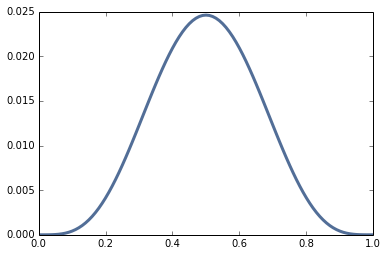

In [45]:
beta1 = Beta(5, 5, label='confident') # This looks about right
thinkplot.Pdf(beta1.MakePmf())

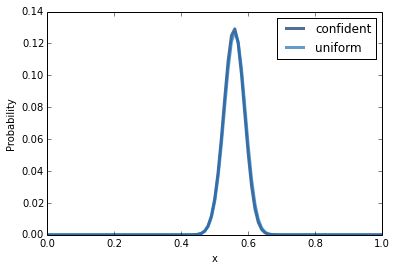

In [59]:
def plotBetas(betas):
    """
    parameters:
      - betas: array of Beta objects
      
    Uses thinkplot to plot both Beta objects on the same plot.
    """
    pmfs = []

    for beta in betas:
        pmfs.append(beta.MakePmf())

    thinkplot.Pdfs(pmfs)
    thinkplot.Config(xlabel='x', ylabel='Probability')

betas = [Beta(5, 5, label='confident'), Beta(label='uniform')] # Compare the distribution above and the uniform distribution
for beta in betas:
    beta.Update((140,110)) # Update with 140 heads and 110 tails
plotBetas(betas)

With this much data, the outcome doesn't really change based off the initial beta distribution.

## Exercise 2
### From Think Bayes Chapter 4

 At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 skeets, sending the match into sudden death. In the first round, both hit 1 of 2 skeets. In the next two rounds, they each hit 2 skeets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet. Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them. To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

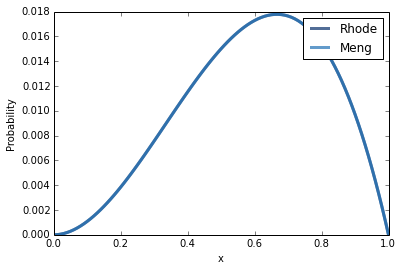

In [244]:
betas = [Beta(3, 2, 'Rhode'), Beta(3, 2, 'Meng')] # With little knowledge, I would assume they both hit more shots than not, and have the same skill
# betas = [Beta(1, 1, 'Rhode'), Beta(1, 1, 'Meng')] # Uniform distribution
plotBetas(betas)

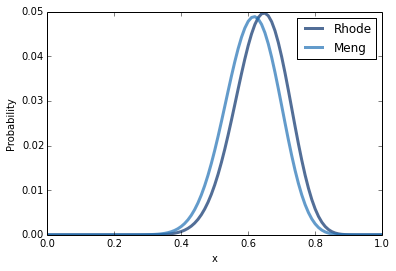

In [245]:
betas[0].Update((15 + 1 + 2 + 2, 10 + 1 + 0 + 0)) # Update Rhode
betas[1].Update((15 + 1 + 2 + 1, 10 + 1 + 0 + 1)) # Update Meng
plotBetas(betas)

In [246]:
# Who is the better player? Well that is likely defined by who has the highest firing rate
numSamples = 10000
samples = []
for beta in betas:
    cdf = beta.MakeCdf(numSamples + 1)
    samples.append(cdf.Sample(numSamples))

np.mean(samples[0] > samples[1]) # Rhode's success rate is superior to Meng's 60% of the time, giving her an edge

0.59130000000000005

In [237]:
# Who will likely win the next match? Let's simulate!
# We assume that during a match, a player has a fixed success rate
numMatches = 10000
skeetsPerMatch = 25
rhodeWins = []
for i in range(numMatches):
    rhodeRate =  samples[0][i]
    mengRate = samples[1][i]
    rhodeSuccess = np.random.binomial(skeetsPerMatch, rhodeRate)
    mengSuccess = np.random.binomial(skeetsPerMatch, mengRate)
    
    # Process tie breakers
    while rhodeSuccess == mengSuccess:
        rhodeSuccess += np.random.binomial(2, rhodeRate) + np.random.binomial(2, rhodeRate)
        mengSuccess += np.random.binomial(2, mengRate) + np.random.binomial(2, mengRate)
        
    rhodeWins.append(rhodeSuccess > mengSuccess) 

np.mean(rhodeWins)
# Rhode wins ~56% of the matches. This is surprising as I expected 60% given the result above. 
# The only difference I could think of was the number of skeet shot per standard match.
# As I increased that to 100, than 1000, I noticed the percentage approaching to 60%.
# I can rationalize this as reducing the variance (particularly for ties), though I'm not sure why the variance consistantly is in favor of the loser.

0.55810000000000004

## Exercise 3
### From Think Bayes Chapter 4
Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability y that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of y.

How does the spread of the posterior distribution depend on y?

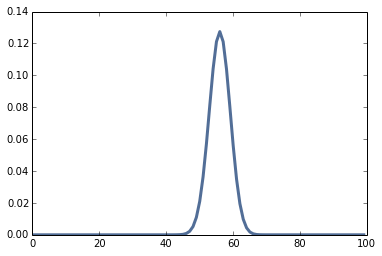

In [287]:
class DrunkEuro(Suite):
    """
    Solve the Euro problem in the case the reporter is wrong y% of the time. Extends Suite.
    self.y is the probablity that the reporter reports the wrong face of the coin (between 0 and 1).
    """
    def Likelihood(self, data, hypo):
        """
        parameters:
          - data: 'H' or 'T'
          - hypo: Hypothesis, or the probability of getting Heads.
          
          Likelihood of the data under the hypothesis.
        """
        if data == 'H':
            # Get heads either from actually getting tails and getting lied to or actually getting heads for real
            return (1 - hypo/100.0) * self.y + hypo/100.0 * (1 - self.y)
        else:
            # Same but opposite for Tails.
            return hypo/100.0 * self.y + (1 - hypo/100.0) * (1 - self.y)
        
distributionPrecision = 100
euro = DrunkEuro(range(distributionPrecision)) # Uniform distribution
euro.y = 0
for toss in 140*'H' + 110*'T':
    euro.Update(toss)

thinkplot.Pdf(euro)

y = 0.0; Peak : 56
y = 0.02; Peak : 56
y = 0.04; Peak : 57
y = 0.06; Peak : 57
y = 0.08; Peak : 57
y = 0.1; Peak : 57
y = 0.12; Peak : 58
y = 0.14; Peak : 58
y = 0.16; Peak : 59
y = 0.18; Peak : 59
y = 0.2; Peak : 60
y = 0.22; Peak : 61
y = 0.24; Peak : 62
y = 0.26; Peak : 62
y = 0.28; Peak : 64
y = 0.3; Peak : 65
y = 0.32; Peak : 67
y = 0.34; Peak : 69
y = 0.36; Peak : 71
y = 0.38; Peak : 75
y = 0.4; Peak : 80
y = 0.42; Peak : 87
y = 0.44; Peak : 99
y = 0.46; Peak : 99
y = 0.48; Peak : 99
y = 0.5; Peak : 99
y = 0.52; Peak : 0
y = 0.54; Peak : 0
y = 0.56; Peak : 0
y = 0.58; Peak : 13
y = 0.6; Peak : 20
y = 0.62; Peak : 25
y = 0.64; Peak : 29
y = 0.66; Peak : 31
y = 0.68; Peak : 33
y = 0.7; Peak : 35
y = 0.72; Peak : 36
y = 0.74; Peak : 38
y = 0.76; Peak : 38
y = 0.78; Peak : 39
y = 0.8; Peak : 40
y = 0.82; Peak : 41
y = 0.84; Peak : 41
y = 0.86; Peak : 42
y = 0.88; Peak : 42
y = 0.9; Peak : 43
y = 0.92; Peak : 43
y = 0.94; Peak : 43
y = 0.96; Peak : 43
y = 0.98; Peak : 44
y = 1.0; Peak

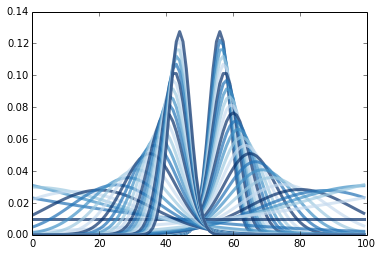

In [295]:
# Lets compare different values of y on a single graph
numValues = 50

for i in range(numValues+1):
    euro = DrunkEuro(range(distributionPrecision), 'y = ' + str(i / numValues))
    euro.y = i / numValues
    
    for toss in 140*'H' + 110*'T':
        euro.Update(toss)
        
    print('y = ' + str(i / numValues) + '; Peak : ' + str(euro.MAP()))
        
    thinkplot.Pdf(euro)

At y = 0, the distribution is where it was in the first iteration of the euro problem (56%).
As y increases, the peak slowly shifts to the right as the curve flattens out (standard deviation increases). 
At y = 0.5, the distribution is uniform. This makes sense as there isn't any information about the coin toss anymore.
For 0.5 < y < 1, the distribution is symmetric to 0 < y < 0.5.
So we get this pretty graph!

## Twin Chess Problem
#### By Allen Downey

Two identical twins are members of my chess club, but they never show up on the same day; in fact, they strictly alternate the days they show up.  I can't tell them apart except that one is a better player than the other:  Avery beats me 60% of the time and I beat Blake 70% of the time.  If I play one twin on Monday and win, and the other twin on Tuesday and lose, which twin did I play on which day?

In [314]:
twins = Pmf(['AB', 'BA']) # Either play Avery then Blake, or vice versa.
twins['AB'] *= 0.4 * 0.3
twins['BA'] *= 0.7 * 0.6
twins.Normalize()
twins.Print()

AB 0.222222222222
BA 0.777777777778


A more typical Bayes problem. The appropriate probability tree is shown below:
        _____  
       /     \    
      W       L      Monday  
     / \     / \  
    W   L   W   L    Tuesday  

The path we are interested in is W-L. In the case we play Avery first, then Blake, the probability at the end of the tree is (1-0.6) * (1-0.7). In the other case, the probability is simply 0.7 * 0.6.
We do a standard Bayesian update, normalize, and voila!

## The Unreliable Amazon Seller Problem
#### By Matthew Beaudouin-Lafon

I bought an item on Amazon because it advertised an impressive lifetime of two years. However, I take a look at the reviews, notice three reviews which state that their item broke after 1.1 year, 2.6 years (a dedicated amazon reviewer!) and 0.7 years. When should I expect my item to break?

##### Solution
To solve this problem, we are trying to find a time distribution. Since we don't have that much data, the choice of  prior is important.  
We can assume that the failure rate follows an exponential distribution, which "describes the time between events in a Poisson process" (from Wikipedia). 
Therefore, we're looking for λ, the failure rate. 
When computing the likelihood however, we need to take into account the range we want. Since the probability that the item breaks after 1.5 years *exactly* is null, instead we can compute the probability that the item breaks after 1.5 years +- 0.1 year.
Our prior is defined by the seller's claim, such that λ = 1 / (2 years)

Note: After a couple hours and realizing that it is 10pm, I've decided to leave this hanging for now. The results I have certainly are incorrect, most likely because I don't understand how to compute the Likelihood function (or how the exponential distribution works).

In [435]:
class Unreliable(Suite):
    """
    Bayesian model to solve the Unreliable Seller Problem. Extends Suite.
    """
    error = 0.1
    
    def Likelihood(self, data, hypo):
        """
        parameters
          -  data: Lifetime of item 
          -  hypo: Lambda for Exponential Distribution (s^-1)
          
        returns: Likelihood of the data under the hypothesis
        """
#         return EvalExponentialCdf(data,  hypo - self.error) - EvalExponentialCdf(data, hypo + self.error)
#         return EvalExponentialPdf(data,  hypo)
#         print(str(hypo) + ' : ' + str(thinkbayes2.EvalNormalCdf(data, hypo)))
        return thinkbayes2.EvalNormalCdf(data, hypo)

0.49699751736657793

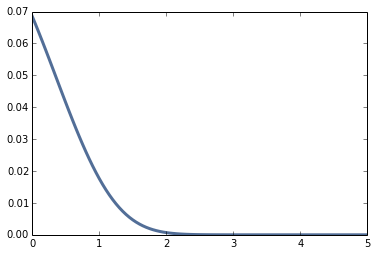

In [442]:
priorBetaDistribution = Beta(2.65, 4).MakePmf() # Get inspired by Beta distributions to get our prior
priorBetaDistribution = Beta(1, 1).MakePmf()
adjustedPrior = Pmf()

for k, v in priorBetaDistribution.Items():  # Make the prior fit over 5 years
    adjustedPrior[k * 5] = v
    
adjustedPrior.Normalize()

unreliable = Unreliable(adjustedPrior)
unreliable.Update(2) # This shouldn't move the pmf laterally because I'm updating at the mean
unreliable.Update(2.6)
unreliable.Update(0.7)
unreliable.Update(1.1)

thinkplot.Pdf(unreliable)
thinkplot.Pdf()
unreliable.Mean()

1.88526480158
pmf: 0.183939720586
cdf: 0.632120558829


0.5

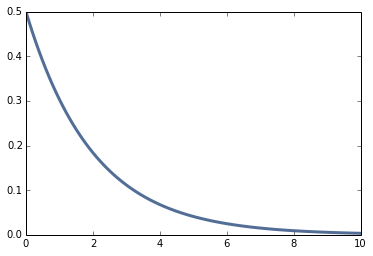

In [433]:
# Experimenting with exponential pdf
lam = 1.0/2
x = 2

epdf = ExponentialPdf(lam)
thinkplot.Pdf(epdf)
print(epdf.MakePmf().Mean())

print('pmf: ' + str(lam * math.exp(-lam * x)))
print('cdf: ' + str(1 - math.exp(-lam * x)))
thinkbayes2.EvalNormalCdf(2, 2)

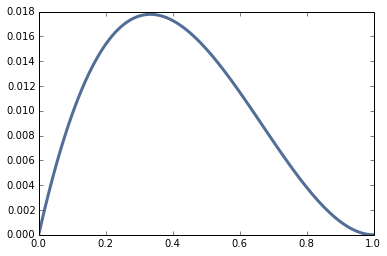

In [465]:
blaster9k = Beta(2, 3)
blaster9k.MAP()
thinkplot.Pdf(blaster9k.MakePmf())

0.23076923076923078

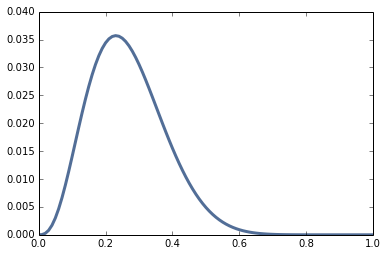

In [464]:
blaster9k.Update((2, 8))
thinkplot.Pdf(blaster9k.MakePmf())
blaster9k.MAP()

In [459]:
class AlienBlaster(Suite):
    def Likelihood(self, data, hypo):
        x = hypo
        return x^4 + 4 * x^2 * (1-x)^2 + (1-x)^4
        
blaster10k = AlienBlaster(np.linspace(0, 1, 100))
blaster10k.Update('literally anything here')
thinkplot.Pdf(blaster10k.MakePdf())

TypeError: unsupported operand type(s) for ^: 'numpy.float64' and 'numpy.float64'

In [456]:
print(np.linspace(0, 1, 100))

[ 0.          0.01010101  0.02020202  0.03030303  0.04040404  0.05050505
  0.06060606  0.07070707  0.08080808  0.09090909  0.1010101   0.11111111
  0.12121212  0.13131313  0.14141414  0.15151515  0.16161616  0.17171717
  0.18181818  0.19191919  0.2020202   0.21212121  0.22222222  0.23232323
  0.24242424  0.25252525  0.26262626  0.27272727  0.28282828  0.29292929
  0.3030303   0.31313131  0.32323232  0.33333333  0.34343434  0.35353535
  0.36363636  0.37373737  0.38383838  0.39393939  0.4040404   0.41414141
  0.42424242  0.43434343  0.44444444  0.45454545  0.46464646  0.47474747
  0.48484848  0.49494949  0.50505051  0.51515152  0.52525253  0.53535354
  0.54545455  0.55555556  0.56565657  0.57575758  0.58585859  0.5959596
  0.60606061  0.61616162  0.62626263  0.63636364  0.64646465  0.65656566
  0.66666667  0.67676768  0.68686869  0.6969697   0.70707071  0.71717172
  0.72727273  0.73737374  0.74747475  0.75757576  0.76767677  0.77777778
  0.78787879  0.7979798   0.80808081  0.81818182  0.